# EDA

## Data Loading

In [1]:
# Insert the parent directory to the system path
import sys
from pathlib import Path
import os

parent_directory = str(Path(os.getcwd()).parent)
sys.path.insert(0, parent_directory)
sys.path

['/home/miki/Desktop/KIFIYA/week-3/Insurance-risk-analysis',
 '/usr/lib/python312.zip',
 '/usr/lib/python3.12',
 '/usr/lib/python3.12/lib-dynload',
 '',
 '/home/miki/Desktop/KIFIYA/week-3/Insurance-risk-analysis/venv/lib/python3.12/site-packages']

In [2]:
# Load data from the db and inspect it
from scripts.load_data import load_from_sqlite

df = load_from_sqlite(
    db_path=f"{parent_directory}/data/cleaned_claim_data.db",
    table_name="claims",
    datetime_cols=["TransactionMonth", "VehicleIntroDate"]
)

df.info()

2025-06-15 19:28:59,048 - INFO - Loaded 999544 records from table 'claims'.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999544 entries, 0 to 999543
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   UnderwrittenCoverID       999544 non-null  int64         
 1   PolicyID                  999544 non-null  int64         
 2   TransactionMonth          999544 non-null  datetime64[ns]
 3   IsVATRegistered           999544 non-null  int64         
 4   Citizenship               999544 non-null  object        
 5   LegalType                 999544 non-null  object        
 6   Title                     999544 non-null  object        
 7   Language                  999544 non-null  object        
 8   Bank                      999544 non-null  object        
 9   AccountType               999544 non-null  object        
 10  MaritalStatus             999544 non-null  object        
 11  Gender                    999544 non-null  object        
 12  Co

## Descriptive statistics

In [3]:
# Do descriptive statistics for key columns
summary = df[["CalculatedPremiumPerTerm", "TotalPremium", "TotalClaims"]].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])
summary

,CalculatedPremiumPerTerm,TotalPremium,TotalClaims
count,999544.000000,999544.000000,999544.000000
mean,116.161425,61.372350,64.340199
std,220.576166,157.014098,2369.567085
min,0.000000,-782.576754,-12002.412281
1%,0.881800,0.000000,0.000000
25%,3.225700,0.000000,0.000000
50%,8.436900,2.179737,0.000000
75%,90.000000,21.929825,0.000000
99%,979.946100,778.293596,0.000000
max,3051.821100,2253.507281,393092.105263


In [4]:
# check the number of negative values for TotalPremium and TotalClaims
print("Negative premiums:", (df["TotalPremium"] < 0).sum())
print("Negative claims:", (df["TotalClaims"] < 0).sum())

Negative premiums: 286
Negative claims: 5


### 🔍 Data Quality Note – Negative Values in Financial Variables

During the descriptive analysis of key financial metrics (`CalculatedPremiumPerTerm`, `TotalPremium`, `TotalClaims`), the following anomalies were detected:

| Column         | Negative Values | Notes |
|----------------|------------------|-------|
| `TotalPremium` | 286              | Likely premium refunds or policy reversals. Should typically be ≥ 0. |
| `TotalClaims`  | 5                | Possibly recoveries or corrections. Claims are usually ≥ 0. |

#### 📊 Interpretation of Summary Statistics

- The data is **heavily right-skewed**:
  - Median `TotalClaims` is **0**, mean is **64.34**, and max is **393,092**.
  - Median `TotalPremium` is **2.18**, mean is **61.37**, max is **2,253.51**.
- A large portion of the portfolio shows **no claims or low premium values**, while a few extreme outliers contribute to high variance.
- These characteristics suggest the presence of **high-risk or high-claim customers**, which may warrant segmentation.

#### ✅ Action Taken

- Negative values are **logged but retained** for now.
- Decision to drop or transform will be made during the modeling phase based on impact and modeling needs.

## Visualizations

In [6]:
import importlib
from scripts import plot_generator
importlib.reload(plot_generator)

<module 'scripts.plot_generator' from '/home/miki/Desktop/KIFIYA/week-3/Insurance-risk-analysis/scripts/plot_generator.py'>

2025-06-15 19:30:44,893 - INFO - PlotGenerator initialized
2025-06-15 19:30:51,284 - INFO - Histogram for CalculatedPremiumPerTerm created successfully.
2025-06-15 19:30:57,075 - INFO - Histogram for TotalPremium created successfully.
2025-06-15 19:31:02,994 - INFO - Histogram for TotalClaims created successfully.


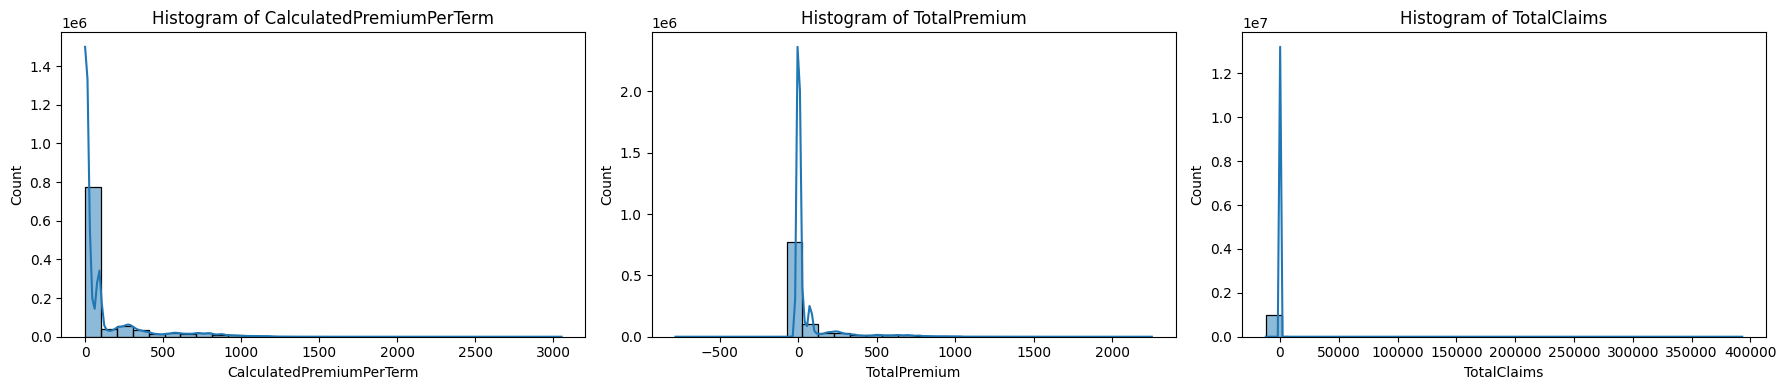

In [8]:
# Plot histograms for major columns
from scripts.plot_generator import PlotGenerator

plotter = PlotGenerator()
plotter.plot_histogram(df=df, columns=["CalculatedPremiumPerTerm", "TotalPremium", "TotalClaims"])

2025-06-15 19:31:41,678 - INFO - Histogram for cubiccapacity created successfully.
2025-06-15 19:31:47,302 - INFO - Histogram for kilowatts created successfully.


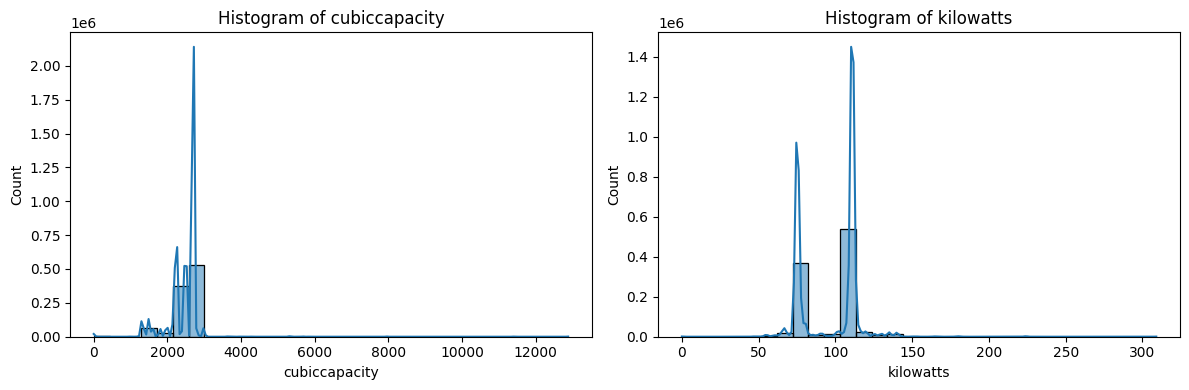

In [9]:
# Plot histograms for vehicle specifications
plotter.plot_histogram(df=df, columns=["cubiccapacity", "kilowatts"])